In [1]:
import sys
(sys.version)

'3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]'

In [3]:
!pip install opencv-python

  Using cached numpy-2.2.6-cp311-cp311-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.16.1 requires numpy<2.0.0,>=1.23.5; python_version <= "3.11", but you have numpy 2.2.6 which is incompatible.

[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install -r requirements.txt

  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import shutil
import secrets
import pickle
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image, ImageFile

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# TensorFlow / Keras (compatible with 3.11)
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    Dropout, Flatten, Dense
)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16


In [3]:
from pathlib import Path
TEST_DIR = "./dataset/imgs/test"
TRAIN_DIR = "./dataset/imgs/train"
MODEL_PATH = "./model"
PICKLE_PATH = Path("./pickle_files")
TEST_CSV_PATH = "./csv_files/test.csv"
TRAIN_CSV_PATH = "./csv_files/train.csv"

In [4]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
else:
    shutil.rmtree(MODEL_PATH)
    os.makedirs(MODEL_PATH)
if not os.path.exists(PICKLE_PATH):
    os.makedirs(PICKLE_PATH)

In [5]:
gen_per_image = 1
gen_per_class = 200
rotation_range = 5
width_shift_range = 0.02
height_shift_range = 0.02
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
fill_mode = "nearest"

In [6]:
height_shift_range = 0.02
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
fill_mode = "nearest"

def increase_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def change_contrast(img, level):
    img = Image.fromarray(img.astype('uint8'))
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return np.array(img.point(contrast))

def pad_img(img):
    h, w = img.shape[:2]
    new_h = int((5 + secrets.randbelow(16)) * h / 100) + h
    new_w = int((5 + secrets.randbelow(16)) * w / 100) + w

    full_sheet = np.ones((new_h, new_w, 3)) * 255

    p_X = secrets.randbelow(new_h - img.shape[0])
    p_Y = secrets.randbelow(new_w - img.shape[1])

    full_sheet[p_X : p_X + img.shape[0], p_Y : p_Y + img.shape[1]] = img

    full_sheet = cv2.resize(full_sheet, (w, h), interpolation = cv2.INTER_AREA)

    return full_sheet.astype(np.uint8)

def preprocess_img(img):
    img = np.array(img)

    x = secrets.randbelow(2)

    if x == 0:
        # img = pad_img(img)
        img = increase_brightness(img, secrets.randbelow(26))
        img = change_contrast(img, secrets.randbelow(51))
    else:
        # img = pad_img(img)
        img = change_contrast(img, secrets.randbelow(51))
        img = increase_brightness(img, secrets.randbelow(26))

    return img

In [7]:
BATCH_SIZE = 128
IMAGE_SIZE = 224
NUM_EPOCHS = 25

In [8]:
datagen = ImageDataGenerator(
        rotation_range = rotation_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range,
        shear_range = shear_range,
        zoom_range = zoom_range,
        horizontal_flip = horizontal_flip,
        fill_mode = fill_mode,
        validation_split = 0.2,
        preprocessing_function = preprocess_img)


train_data = datagen.flow_from_directory(TRAIN_DIR,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        subset='training',shuffle=True)

valid_data = datagen.flow_from_directory(TRAIN_DIR,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        subset='validation',shuffle=True)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [9]:
model = VGG16(include_top=False)
model.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
vgg16_model_fine_tuned = Sequential()
vgg16_model_fine_tuned.add(GlobalAveragePooling2D(input_shape=model.output_shape[1:]))
vgg16_model_fine_tuned.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))
vgg16_model_fine_tuned = Model(inputs = model.input, outputs = vgg16_model_fine_tuned(model.output))

vgg16_model_fine_tuned.summary()

c:\Users\mg276\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\pooling\base_global_pooling.py:12: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 14,719,818 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
for layer in vgg16_model_fine_tuned.layers[:15]:
    layer.trainable = False

In [12]:
vgg16_model_fine_tuned.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
    metrics=['accuracy']
)


In [13]:
filepath = os.path.join(MODEL_PATH,"Vgg16_fine_tuned_batchwise_best_model.keras")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode="max")
callbacks_list = [checkpoint]

In [14]:
model_history = vgg16_model_fine_tuned.fit(train_data,validation_data = valid_data,epochs=NUM_EPOCHS, shuffle=True,callbacks=callbacks_list)

Epoch 1/25


c:\Users\mg276\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1300 - loss: 3.5404
Epoch 1: val_accuracy improved from -inf to 0.26110, saving model to ./model\Vgg16_fine_tuned_batchwise_best_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 671s 5s/step - accuracy: 0.1303 - loss: 3.5334 - val_accuracy: 0.2611 - val_loss: 2.0907
Epoch 2/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3490 - loss: 1.8906
Epoch 2: val_accuracy improved from 0.26110 to 0.69761, saving model to ./model\Vgg16_fine_tuned_batchwise_best_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 760s 5s/step - accuracy: 0.3498 - loss: 1.8887 - val_accuracy: 0.6976 - val_loss: 1.0173
Epoch 3/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7426 - loss: 0.8467
Epoch 3: val_accuracy improved from 0.69761 to 0.87079, saving model to ./model\Vgg16_fine_tuned_batchwise_best_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 763s 5s/step - accuracy: 0.7430 - loss: 0.8456 - val_accuracy: 0.8708 - val_loss: 0.4360
Epoch 4/25
141/141 ━━━━━━━━━━━━━━

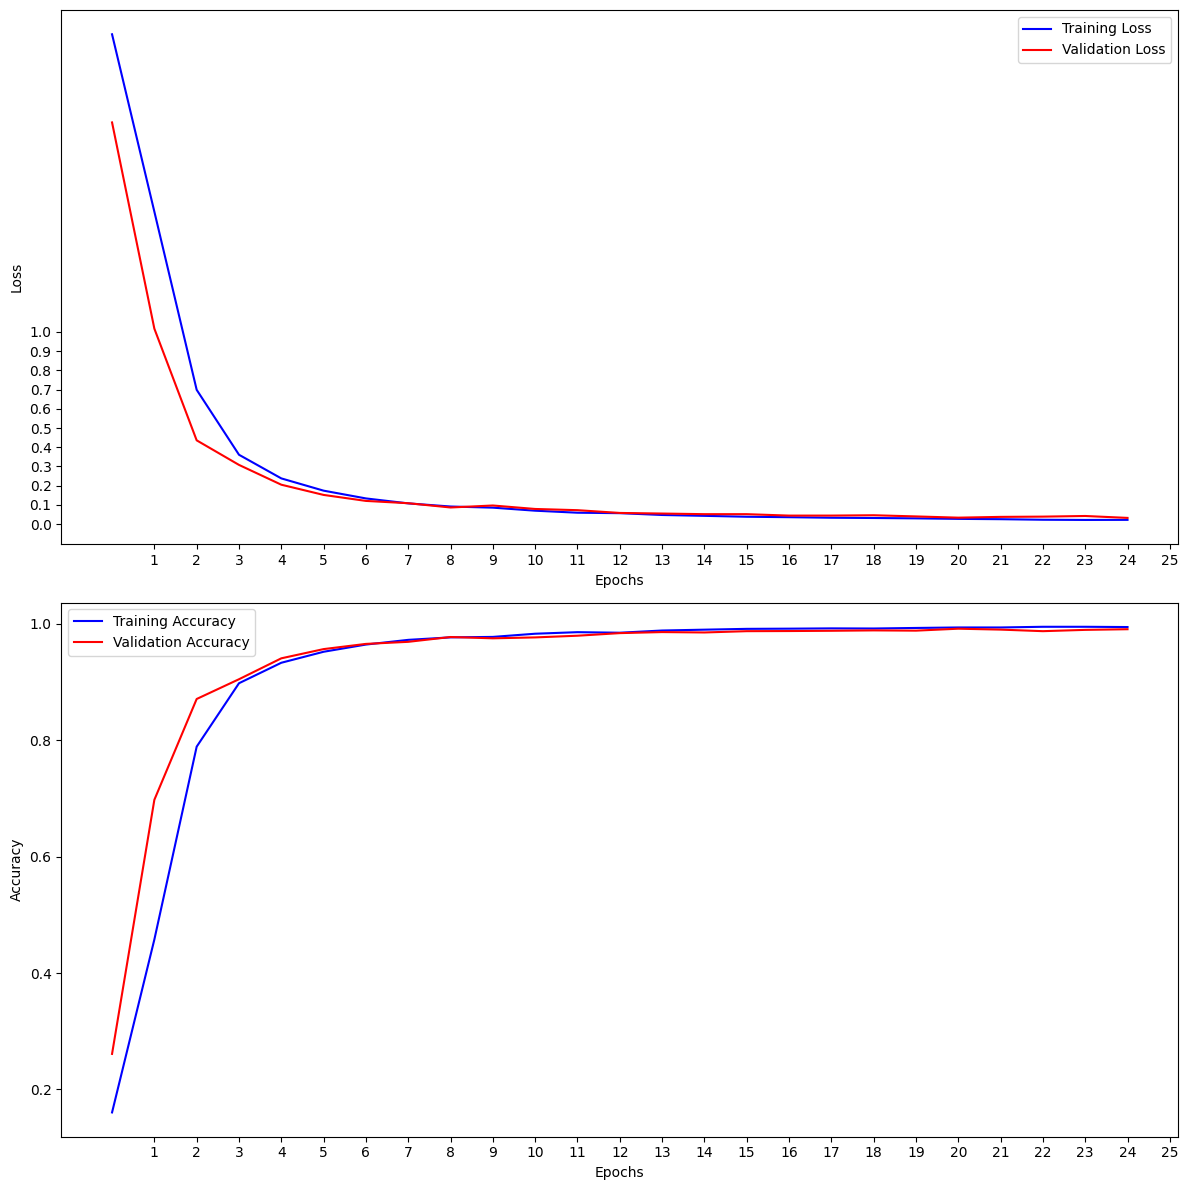

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# ----- LOSS -----
ax1.plot(model_history.history['loss'], color='b', label="Training Loss")
ax1.plot(model_history.history['val_loss'], color='r', label="Validation Loss")

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax1.set_xticks(np.arange(1, len(model_history.history['loss']) + 1, 1))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.legend()

# ----- ACCURACY -----
ax2.plot(model_history.history['accuracy'], color='b', label="Training Accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r', label="Validation Accuracy")

ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")

ax2.set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1, 1))
ax2.legend()

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(MODEL_PATH,"Vgg16_shallow_non_batch_graph.png"))

In [16]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap="Blues")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"Vgg16_shallow_non_batch_confusion_matrix.png"))
    return fig

In [17]:
from sklearn.metrics import confusion_matrix
import numpy as np

def print_heatmap(n_labels, n_predictions, class_names):

    # --- FIX 1: Ensure labels are class indices ---
    if n_labels.ndim > 1:
        labels = n_labels.argmax(axis=1)
    else:
        labels = n_labels

    # --- FIX 2: Ensure predictions are class indices ---
    if n_predictions.ndim > 1:
        predictions = n_predictions.argmax(axis=1)
    else:
        predictions = n_predictions

    # --- Compute confusion matrix ---
    matrix = confusion_matrix(labels, predictions)

    # Normalize rows (%)
    row_sum = matrix.sum(axis=1, keepdims=True)
    c_m = (matrix / row_sum * 100).astype(np.uint8)

    # Plot
    heatmap = print_confusion_matrix(c_m, class_names, figsize=(18, 10), fontsize=20)


In [22]:
# Correct class names (in label order)
TRAIN_CSV = pd.read_csv(TRAIN_CSV_PATH)
labels_list = sorted(TRAIN_CSV['ClassName'].unique().tolist())
labels_id = {label_name: i for i, label_name in enumerate(labels_list)}
TRAIN_CSV['ClassName'] = TRAIN_CSV['ClassName'].map(labels_id)
labels = to_categorical(TRAIN_CSV['ClassName'])
print(labels.shape)

def path_to_tensor(img_path):
    """Load single image and convert to 4D tensor."""
    img_path = str(img_path)  # Windows-safe path
    img = image.load_img(img_path, target_size=(64, 64))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    """Load all image paths → stacked tensor."""
    list_of_tensors = []
    for img_path in tqdm(img_paths, desc="Loading images"):
        list_of_tensors.append(path_to_tensor(img_path))
    return np.vstack(list_of_tensors)

# train-test split
xtrain, xtest, ytrain, ytest = train_test_split(
    TRAIN_CSV.iloc[:, 0].astype(str),   # make sure paths are strings
    labels,
    test_size=0.2,
    random_state=42
)

# convert image paths → images
train_tensors = paths_to_tensor(xtrain).astype("float32") / 255.0 - 0.5
valid_tensors = paths_to_tensor(xtest).astype("float32") / 255.0 - 0.5

(22424, 10)


Loading images: 100%|██████████| 4485/4485 [00:05<00:00, 872.56it/s]


Loading images: 100%|██████████| 4485/4485 [00:05<00:00, 884.39it/s]


141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step


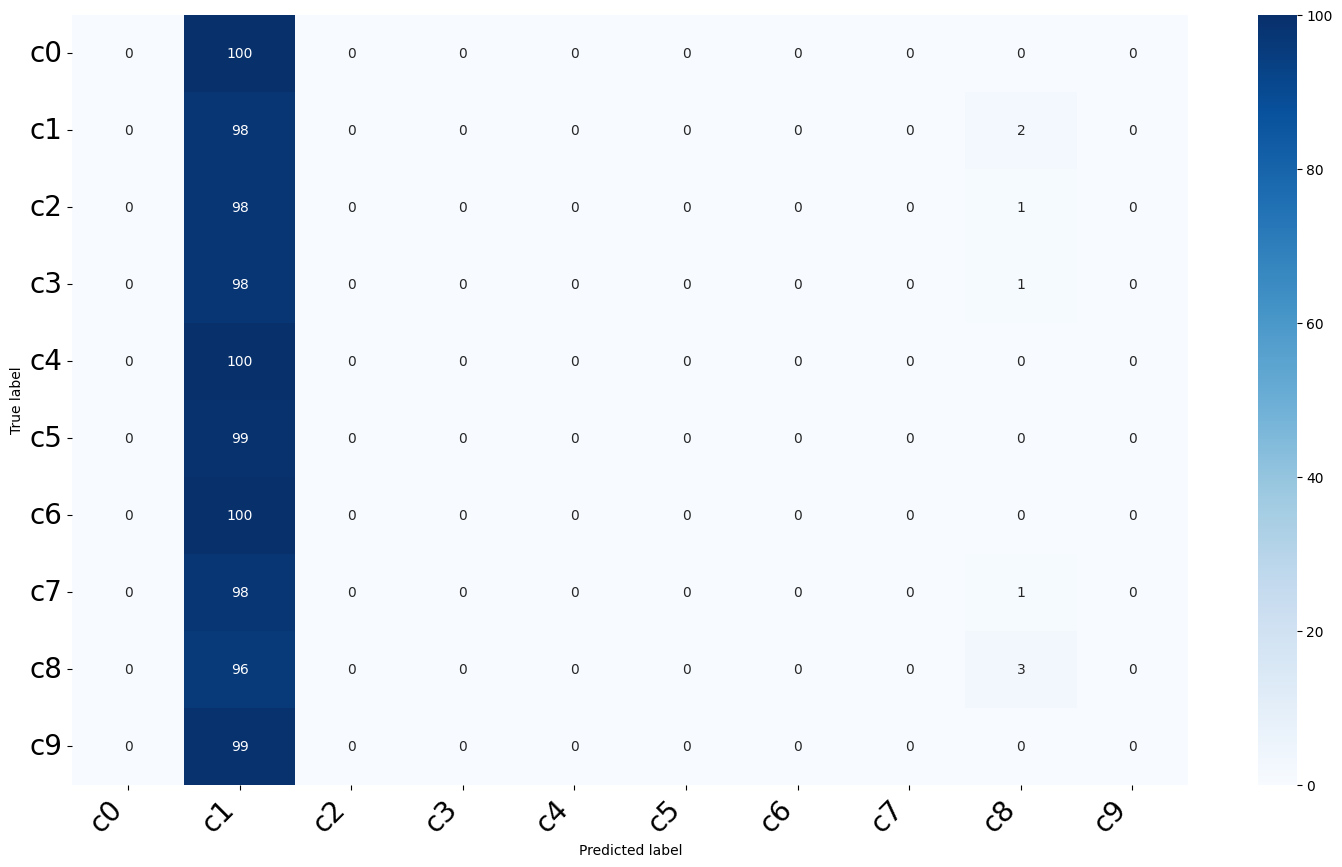

In [23]:

labels_map = {label: idx for idx, label in enumerate(labels_list)}
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5
ypred = vgg16_model_fine_tuned.predict(valid_tensors, verbose=1)

print_heatmap(ytest, ypred, class_names)



In [26]:
ypred_class = np.argmax(ypred,axis=1)
ypred = vgg16_model_fine_tuned.predict(ytest, verbose=1)

ValueError: as_list() is not defined on an unknown TensorShape.

In [25]:
from sklearn.metrics import precision_score,recall_score,f1_score
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets